<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/l5_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb

     |████████████████████████████████| 793 kB 5.0 MB/s 
     |████████████████████████████████| 380 kB 56.2 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=439861103ebd401d43733e17bb8eb01ccc46572e44cde8ccde581fb715219792
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2022-03-04 00:41:11--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  17.4MB/s    in 0.3s    

2022-03-04 00:41:12 (17.4 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]



In [ ]:
!ls

ml-100k.zip  ml-100k.zip.1  sample_data


In [ ]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
from fastai import *
from fastai.vision import *
from fastai.collab import *
from ipdb import set_trace as st

In [ ]:
import pandas as pd
path = Path('/content/ml-100k')
df = pd.read_csv(path/'u.data', header = None, delimiter = '\t', names = ['u_id', 'm_id', 'rating', 'ts'])
data = CollabDataBunch.from_df(df, user_name = 'u_id', item_name = 'm_id', rating_name = 'rating')
data.show_batch()

u_id,m_id,target
753,182,3.0
663,710,3.0
291,223,5.0
758,234,4.0
196,269,3.0


epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


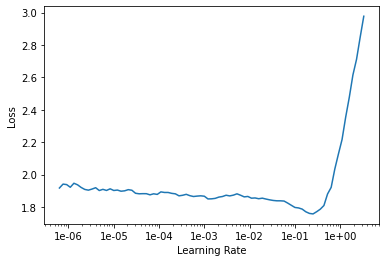

In [ ]:
learn = collab_learner(data, n_factors = 40, y_range = [0, 5.5], bn_final = True, wd = 1e-02, metrics = abs_error)
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-03)

epoch,train_loss,valid_loss,abs_error,time
0,1.159697,1.148571,0.883734,00:10


In [ ]:
# u, m = max(set(df["u_id"])), max(set(df['m_id']))

def abs_error(yhat, y):
  yhat, y = yhat.squeeze(), y.squeeze()
  return torch.mean(torch.abs(yhat - y))

class MyCollab(nn.Module):
  def __init__(self, n_factors, y_range):
    super().__init__()
    nu, ni = u + 1, m + 1
    self.u, self.u_b, self.i, self.i_b = [nn.Embedding(i, j) for i, j in [(nu, n_factors), (nu, 1), (ni, n_factors), (ni, 1)]]
    self.y_range = y_range

  def rangify(self, yhat):
    yhat = torch.sigmoid(yhat)
    # print('d, ', yhat.shape)
    res = (yhat * (self.y_range[1] - self.y_range[0])) + self.y_range[0]
    # print('e, ', res.shape)
    return res

  def forward(self, ud, id):
    # print('a, ', ud.shape, id.shape, max(ud), max(id))
    yhat = torch.sum(self.u(ud) * self.i(id), 1)
    # print('b, ', yhat.shape)
    yhat += self.u_b(ud).squeeze(1) + self.i_b(id).squeeze(1)
    # print('c, ' , yhat.shape)
    return self.rangify(yhat)


In [ ]:
x, y = next(iter(data.valid_dl))

In [ ]:
collab = MyCollab(40, [0, 5.5]).cuda()
my_learner = CollabLearner(data, collab, metrics = abs_error, wd = 1e-01)

epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


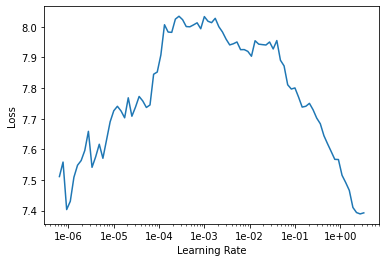

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()

In [ ]:
my_learner.save('st_1')

In [ ]:
my_learner.load('st_1')
my_learner.fit(3, lr = 1e-02)

epoch,train_loss,valid_loss,abs_error,time
0,1.109462,1.110967,0.838212,00:08
1,0.881006,0.917615,0.764070,00:08
2,0.821404,0.915065,0.762085,00:08


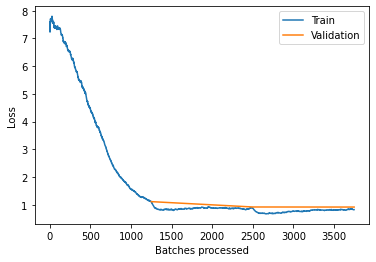

In [ ]:
my_learner.recorder.plot_losses()

epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


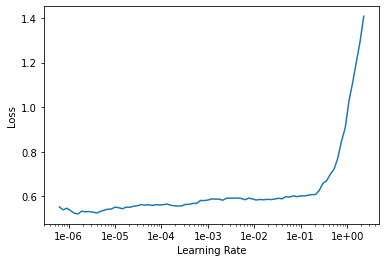

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()

In [ ]:
my_learner.save('st_2')

In [ ]:
my_learner.load('st_2')
my_learner.fit(3, lr = 1e-03  )

epoch,train_loss,valid_loss,abs_error,time
0,0.550358,0.872527,0.744443,00:08
1,0.515207,0.863807,0.740663,00:09
2,0.475786,0.863827,0.740246,00:08


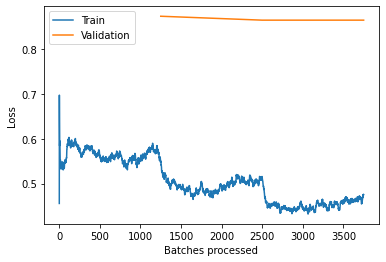

In [ ]:
my_learner.recorder.plot_losses()

In [ ]:
emb = nn.Embedding(20, 10)

In [ ]:
for i in emb.parameters():
  w = i
w.shape

torch.Size([20, 10])

In [ ]:
torch.mean(w[0]), torch.mean(w), torch.std(w[0]), torch.std(w)

(tensor(-0.4227, grad_fn=<MeanBackward0>),
 tensor(-0.0238, grad_fn=<MeanBackward0>),
 tensor(0.3475, grad_fn=<StdBackward0>),
 tensor(0.8944, grad_fn=<StdBackward0>))

In [ ]:
torch.max(w), torch.min(w)

(tensor(2.4258, grad_fn=<MaxBackward1>),
 tensor(-2.8512, grad_fn=<MinBackward1>))

In [ ]:
with torch.no_grad():
  st()
  emb.weight.normal_()

In [ ]:
from fastai.datasets import untar_data
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [ ]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/2')]

In [ ]:
#test
from fastai.vision.image import open_image
img = open_image((path/'training'/'1').ls()[10])
img.data.reshape(2352).shape

torch.Size([2352])

In [ ]:
import random
valid_index = random.sample(range(60000), 12000)

x, y = [], []

for i in (path/'training').ls():
  for j in (path/'training'/i).ls():
    x.append(open_image((path/'training'/i/j)).data.reshape(2352))
    y.append(torch.tensor(int(i.name)))

x_train, y_train, x_valid, y_valid = [], [], [], []

for i in range(60000):  
  if (i in valid_index):
    x_valid.append(x[i])
    y_valid.append(y[i])
  else:
    x_train.append(x[i])
    y_train.append(y[i])

x_train = torch.stack(x_train)
x_valid = torch.stack(x_valid)
y_train = torch.stack(y_train)
y_valid = torch.stack(y_valid)

In [ ]:
y_train.shape

torch.Size([48000])

In [ ]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [ ]:
from fastai.basic_data import DataBunch
data = DataBunch.create(train_ds = train_ds, valid_ds = valid_ds)

In [ ]:
x, y = next(iter(data.train_dl))

In [ ]:
x.shape, y.shape

(torch.Size([64, 2352]), torch.Size([64]))

In [ ]:
lin = nn.Linear(in_features = 2352, out_features = 10).cuda()

In [ ]:
yhat = lin(x)

In [ ]:
for i in lin.parameters():
  print(i.dtype)

torch.float32
torch.float32


In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func(yhat, y)

tensor(2.3357, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
from torch.nn.parameter import Parameter
class Linear(nn.Module):
  def __init__(self, n_in, n_out):
    super().__init__()
    self.w = Parameter(torch.rand(n_in, n_out, dtype = torch.float32, device = 'cuda'))
    self.bias = Parameter(torch.rand(n_out, 1, dtype = torch.float32, device = 'cuda').squeeze())

    self.relu = nn.ReLU()
  
  def forward(self, x):
    return self.relu(torch.matmul(x, self.w) + self.bias)

In [ ]:
yhat = lin(x)

In [ ]:
loss_func(yhat,)

tensor(6.3222, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
lin = Linear(2352, 10).cuda()

def update(lr = 1e-01):
  c = 0
  for x, y in iter(data.train_dl):
    yhat = lin(x)
    loss = loss_func(yhat, y)
    if (c %30 == 0):
      print(loss.item())
    loss.backward()
    c += 1
    with torch.no_grad():
      for param in lin.parameters():
        param.sub_(lr*param.grad)
        param.grad.zero_()

In [ ]:
update()

8.853636741638184
1.5475369691848755
0.9582372903823853
0.636381983757019
0.8262552618980408
0.7866864204406738
0.808962345123291
0.3789233863353729
0.5753921866416931
0.7840938568115234
0.4792977273464203
0.5973223447799683
0.7937490344047546
0.4107481837272644
0.8635520339012146
0.47005966305732727
0.42159098386764526
0.7905972003936768
0.176954984664917
0.18263453245162964
0.5495290160179138
0.4643326997756958
0.7765210270881653
0.45138877630233765
0.4695459008216858


In [ ]:
vx, vy = next(iter(data.valid_dl))
vyhat = lin(vx)

In [ ]:
loss_func(vyhat, vy)

tensor(0.3181, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
temp = vyhat.argmax(1)
temp, vy

(tensor([9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 9, 9, 9, 2, 9, 9,
         9, 9, 9, 9, 9, 9, 9, 9, 4, 9, 9, 9, 9, 9, 3, 9, 9, 8, 3, 7, 9, 9, 9, 9,
         9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3], device='cuda:0'),
 tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
         9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
         9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0'))

In [ ]:
def accuracy(yhat, y):
  return 100 * torch.sum(yhat.argmax(1) == y)/len(y)

In [ ]:
losses = []
accs = []
for vx, vy in iter(data.valid_dl):
  vyhat = lin(vx)
  losses.append(loss_func(vyhat, vy))
  accs.append(accuracy(vyhat, vy))

torch.mean(torch.stack(losses)), torch.mean(torch.stack(accs))

(tensor(0.4621, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(87.2673, device='cuda:0'))

In [ ]:
class MyLearner(nn.Module):
  def __init__(self, layers = []):
    super().__init__()
    self.layers = layers
    ws = [Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)]
    self.ws = Parameter(nn.Sequential(*ws))
  
  def forward(self, x):
    return self.ws(x)

NameError: ignored